# OOPython

Задача 5. Численное решение ОДУ.

Борисов Дмитрий, 373гр.

### Воспользуемся ранее получеными результатами.
#### Иерархия классов для формул численного дифференцирования:
* Forward 1st Order Derivative - ForwardDerivative
* Backward 1st Order Derivative - BackwardDerivative
* Central 2nd Order Derivative - CentralDerivative
* Symmetric 4th Order Derivative - FourthDerivative
* Symmetric 6th Order Derivative - FifthDerivative

In [1]:
class AbstractDerivative:
    def __init__(self, function, step = 1e-5):
        self._function = function
        self._step = float(step)
        
    def __call__(self, x):
        raise NotImplementedError
        
class ForwardDerivative(AbstractDerivative):
    __MethodName = 'Forward 1st Order Derivative'
    def getName(self):
        return self.__MethodName

    def __call__(self, x):
        return (self._function(x + self._step) - self._function(x)) / self._step

class BackwardDerivative(AbstractDerivative):
    __MethodName = 'Backward 1st Order Derivative'
    def getName(self):
        return self.__MethodName
 
    def __call__(self, x):
        return (self._function(x) - self._function(x - self._step)) / self._step

class CentralDerivative(AbstractDerivative):
    __MethodName = 'Central 2nd Order Derivative'
    def getName(self):
        return self.__MethodName

    def __call__(self, x):
        return (self._function(x + self._step) - self._function(x - self._step)) / (2 * self._step)
    
class FourthDerivative(AbstractDerivative):
    __MethodName = 'Symmetric 4th Order Derivative'
    def getName(self):
        return self.__MethodName

    def __call__(self, x):
        return 4. / 3 * (self._function(x + self._step) - self._function(x - self._step)) / (2 * self._step) \
    - 1. / 3 * (self._function(x + 2 * self._step) - self._function(x - 2 * self._step)) / (4 * self._step)
    
class FifthDerivative(AbstractDerivative):
    __MethodName = 'Symmetric 6th Order Derivative'
    def getName(self):
        return self.__MethodName

    def __call__(self, x):
        return 3. / 2 * (self._function(x + self._step) - self._function(x - self._step)) / (2 * self._step) \
    - 3. / 5 * (self._function(x + 2 * self._step) - self._function(x - 2 * self._step)) / (4 * self._step) \
    + 1. / 10 * (self._function(x + 3 * self._step) - self._function(x - 3 * self._step)) / (6 * self._step)

### 1. Создать иерархию классов, реализующих численное интегрированиезадачи Коши для автономного скалярного ОДУ:
* явный метод Эйлера 1-го порядка точности
* метод Эйлера с пересчетом 2-го порядка точности
* метод Рунге-Кутты 3-го порядка точности
* метод Рунге-Кутты 4-го порядка точности
* неявный метод трапеций 2-го порядка точности

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class LogisticRightHandSide:
    def __init__(self, alpha, R):
        self._alpha, self._R = float(alpha), float(R)
    
    def __call__(self, u):
        return self._alpha * u * (1 - u / self._R)

In [4]:
class AbstractOneStepODESolver:
    _name = 'Abstract ODE solver'
    
    def __init__(self):
        print 'A %s solver initialized.' % self.__class__.__name__
    
    def SetRightHandSide(self, function):
        self._function = function
    
    def SetInitialCondition(self, value):
        self._initialValue = value
       
    def SetGrid(self, numBlocks, tStart, tEnd):
        self._numBlocks, self._numPoints = numBlocks, numBlocks + 1
        self._dt = float(tEnd) / float(self._numBlocks)
        self._solutionArray = np.zeros(self._numPoints)
        self._timeArray = np.linspace(tStart, tEnd, self._numPoints)
        self._tStart, self._tEnd = tStart, tEnd     
        
    def GetStepNumber(self):
        return self._counter
    
    def AdvanceNextStep(self):
        raise NotImplementedError       
    
    def Solve(self): 
        self._counter = 0        
        self._solutionArray[0] = self._initialValue
        for i in range(self._numBlocks):
            self._solutionArray[i + 1] = self.AdvanceNextStep()
            self._counter += 1
        
        return self._solutionArray, self._timeArray

    def PlotSolution(self):
        plt.figure()
        plt.plot(self._timeArray, self._solutionArray, '-', linewidth=4)
        plt.grid('on')
        plt.title('Solution via %s' % self._name)
        plt.xlabel('t, s')
        plt.ylabel('Normalized population')
        plt.show()

In [5]:
class SolveODEEuler1stOrder(AbstractOneStepODESolver):
    _name = '1st order Euler ODE solver'
    def AdvanceNextStep(self):
        uOld = self._solutionArray[self._counter]
        uNew = uOld + self._dt * self._function(uOld)     
        return uNew

class SolveODEModifiedEuler2ndOrder(AbstractOneStepODESolver):
    _name = '2nd order Modified Euler ODE solver'
    def AdvanceNextStep(self):
        uOld = self._solutionArray[self._counter]
        uStar = uOld + self._dt * self._function(uOld)
        uNew = uOld + self._dt / 2. * (self._function(uOld) + self._function(uStar))
        return uNew
    
class SolveODERungeKutta3(AbstractOneStepODESolver):
    _name = '3rd order Runge-Kutta ODE solver'
    def AdvanceNextStep(self):
        uOld = self._solutionArray[self._counter]        
        f, dt = self._function, self._dt
        
        k1 = dt * f(uOld)
        k2 = dt * f(uOld + k1 / 2.)
        k3 = dt * f(uOld + 2 * k2 - k1)      
        uNew = uOld + (k1 + 4. * k2 + k3) / 6.   
        return uNew
    
class SolveODERungeKutta4(AbstractOneStepODESolver):
    _name = '4th order Runge-Kutta ODE solver'
    def AdvanceNextStep(self):
        uOld = self._solutionArray[self._counter]        
        f, dt = self._function, self._dt
        
        k1 = dt * f(uOld)
        k2 = dt * f(uOld + k1 / 2.)
        k3 = dt * f(uOld + k2 / 2.)
        k4 = dt * f(uOld + k3)       
        uNew = uOld + (k1 + 2. * k2 + 2. * k3 + k4) / 6.
        return uNew
    
class SolveODEImplicitTrapezium2ndOrder(AbstractOneStepODESolver):
    _name = '2nd order Implicit Trapezium method solver'
    
    def NewtonFunction(self, uNew):
        uOld = self._solutionArray[self._counter]
        return uNew - uOld - 0.5 * self._dt * (self._function(uOld) + self._function(uNew))
    
    def NewtonStep(self, u_k):
        NewtonDerivative = CentralDerivative(self.NewtonFunction, self._dt)
        u_next = u_k - self.NewtonFunction(u_k) / NewtonDerivative(u_k)
        return u_next
    
    def AdvanceNextStep(self):
        uOld = self._solutionArray[self._counter]        
        f, dt = self._function, self._dt
        error = 1e-3
        
        u0 = uOld + dt * f(uOld)
        u1 = self.NewtonStep(u0)
        
        while abs(u1 - u0) > error:
            u0 = u1
            u1 = self.NewtonStep(u0)
        
        return u1

### 2. Тестирование работы классов

In [6]:
listOfSolvers = [SolveODEEuler1stOrder(), SolveODEModifiedEuler2ndOrder(), SolveODERungeKutta3(),\
                 SolveODERungeKutta4(), SolveODEImplicitTrapezium2ndOrder()]

A SolveODEEuler1stOrder solver initialized.
A SolveODEModifiedEuler2ndOrder solver initialized.
A SolveODERungeKutta3 solver initialized.
A SolveODERungeKutta4 solver initialized.
A SolveODEImplicitTrapezium2ndOrder solver initialized.


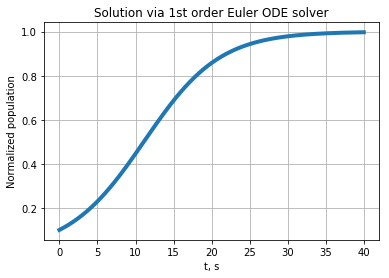

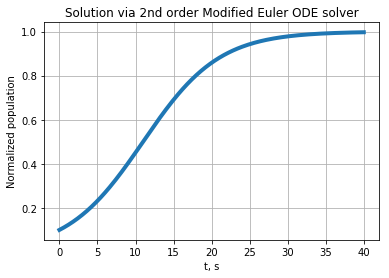

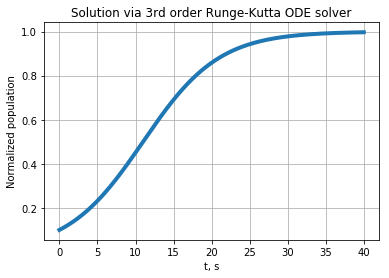

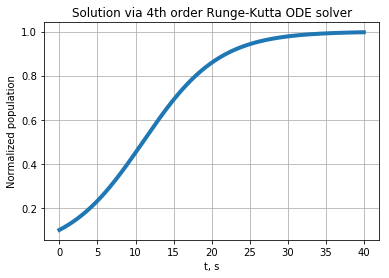

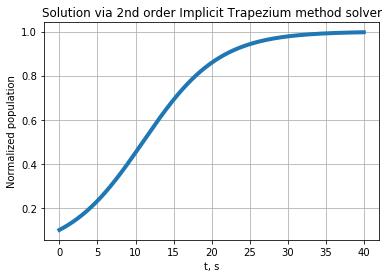

In [7]:
alpha, R = 0.2, 1
rightHandSide = LogisticRightHandSide(alpha, R)

numBlocks = 200
tStart, tEnd = 0, 40

for solver in listOfSolvers:
    solver.SetRightHandSide(rightHandSide)
    solver.SetInitialCondition(0.1)
    solver.SetGrid(numBlocks, tStart, tEnd)
    solver.Solve()
    solver.PlotSolution()